In [1]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [5]:
# !! DO NOT MODIFY THIS CELL !!

# Download and preprocess the dataset.
# fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
# Convert categorical features into one-hot encode
categorical_features = ['cp','thal','slope','restecg']
X = pd.get_dummies(X, columns=categorical_features)

y = heart_disease.data.targets
print(f"Number of samples in all full dataset is: {len(X)}.")

# Check if our train set has missing value
na_in_features = X.isna().any(axis=1).sum()
na_in_trainY = y.isna().sum()
print(f"Number of rows with missing values in features: {na_in_features}")

# Drop the rows with missing values.
indices_with_nan = X.index[X.isna().any(axis=1)]
X = X.drop(indices_with_nan)
y = y.drop(indices_with_nan)

# Divide train/test
np.random.seed(6464)
msk = np.random.rand(len(X)) < 0.75
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

# Convert problem to binary problem
X_train = np.array(X_train,dtype='float')
X_test = np.array(X_test,dtype='float')
y_train = np.array([-1 if i==0 else 1 for i in y_train.values],dtype='float')
y_test = np.array([-1 if i==0 else 1 for i in y_test.values],dtype='float')

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Number of samples in all full dataset is: 303.
Number of rows with missing values in features: 4
Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [6]:
# Normalize X_train and X_test using the statistics of X_train.
# 1. Compute the mean and standard deviation for each feature in X_train
# 2. Subtract the mean from each feature and divide by the standard deviation
#    for both X_train and X_test.

mean = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [7]:
# Print the mean and standard deviation of the first and last feature.

print(f"Mean of the first feature: {mean[0]:.2f}")

Mean of the first feature: 54.99


In [9]:
# Train SVM

# Complete the `trainSVM` function to find the optimal w and b that minimize
# the primal SVM objective given in the write-up.
# The function takes three inputs:
# - trainX: the normalized train features with shape (#train_samples, #features)
# - trainY: train labels with shape (#train_samples,)
# - C: C parameter of the minimization problem
# The function should return a three-tuple with:
# - w: the weight vector with shape (#features,)
# - b: the bias. A scalar with shape (1,)
# - xi: the slack variables with shape (#train_samples,)

# You can use cvxpy that we imported as cp
# You may find cp.Variable, cp.Minimize, cp.Problem useful
# For the problem solver, prefer the default, cp.CLARABEL

def trainSVM(trainX, trainY, C):
    w = cp.Variable(trainX.shape[1])
    b = cp.Variable()
    xi = cp.Variable(trainX.shape[0])
    
    objective = cp.Minimize(0.5*cp.norm(w,2)**2 + C*cp.sum(xi))
    constraints = [cp.multiply(trainY,(trainX@w+b)) >= 1-xi, xi >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value, b.value, xi

In [10]:
# Solve SVM with C = 1 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

Y = y_train
C = 1
w, b, xi = trainSVM(X_train, Y, C)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"First three slack variables: {xi[:3]}")


First three weights: [-0.01280084  0.51706872  0.27813637]
b: 0.08109278708401382
First three slack variables: var3[0:3]


In [11]:
# Solve SVM with C = 0 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

C = 0
w, b, xi = trainSVM(X_train, Y, C)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"First three slack variables: {xi[:3]}")


First three weights: [ 3.09523259e-06 -8.18802636e-06 -9.46615246e-06]
b: -10.447621082517728
First three slack variables: var62[0:3]


In [12]:
# Eval SVM

# Write a function to evaluate the SVM model given its `w` and `b` parameters
# on evaluation data `X_eval` and true labels `y_eval`.
#  1. Estimate the labels of `X_eval`.
#  2. Return the ratio of accurately estimated labels by comparing with `y_eval`.


def evalSVM(X_eval, y_eval, w, b):
    y_pred = np.sign(X_eval@w + b)
    return np.mean(y_pred == y_eval)


In [13]:
train_accuracies = []
test_accuracies = []
C_values = []

# For each C value given in the homework, find optimal w, b
# values using the normalized train set. calculate the accuracy
# on train and test sets using found w and b.
# Save those values as we will plot them

for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    w, b, _ = trainSVM(X_train, y_train, C)
    train_acc = evalSVM(X_train, y_train, w, b)
    test_acc = evalSVM(X_test, y_test, w, b)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    C_values.append(C)
    

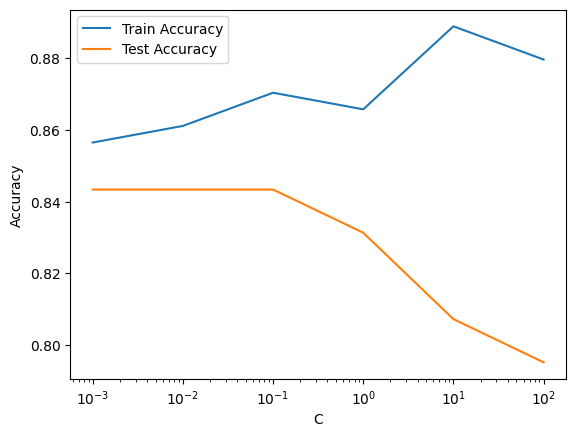

In [14]:
# Plotting and reporting the desired values

plt.plot(C_values, train_accuracies, label='Train Accuracy')
plt.plot(C_values, test_accuracies, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
